In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/home/scidb/HeartRatePatterns/Python"))
from LogisticRegresion import ajustLogisticRegression
from PlotWords import plot_word
from Matrix import convert_matrix
from NMF import generateNMF,auc_model,find_best_NMF

In [2]:
def findpatient(message,table,beats):
    groupsize = table.shape[0]
    deads = sum(table.index.labels[1].tolist())
    percent = -1 if groupsize==0 else deads/groupsize
    if groupsize!=0:
        print(message,"groupsize:%d"%groupsize,"deads:%d"%deads,"percent:{0:.2%}".format(percent),beats)

In [3]:
import psycopg2
def selectPearson(word,dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_statement='SELECT patient,deadpatient,p1 FROM wordspearson WHERE word = %s'
#    print(cur.mogrify(select_statement,locals()))
    cur.execute(select_statement,(word,))
    select = {}
    for row in cur :
        patient=row[0]
        select = {'word':word,"pacientes":patient,"porcentaje de muertos":"{0:.2%}".format(row[1]/patient),"p1":row[2]}
    cur.close()
    conn.close()
    return select

In [4]:
def print_top_words(model, feature_names,topic_index=None):
    result = []
    for topic_idx, topic in enumerate(components):
        features = [{"word":feature_names[i],"p1":topic[i]} 
                    for i in topic.argsort()[:-1] if topic[i] > 0]
        if features!=[] and (topic_index==None or topic_index==topic_idx): result.append({"topic":topic_idx,"features":features})
    return result

In [5]:
def addValue(key,my_dict):
    if key in my_dict:
        my_dict[key] += 1
    else:
        my_dict[key] = 1
    return my_dict

In [6]:
from operator import itemgetter
def predict_proba(compoT,table):
    predicts = modelnmf.predict_proba(compoT)[:,1]
    beats = list(table)
    sortedBeats = []
    numPred = len(predicts)
    nvals={}
    for i in range(0,numPred):
        word = beats[i]
        sel = selectPearson(word)
        if sel=={}:
            print("palabra no encontrada en pearson:",word)
        sortedBeats.append({'word':beats[i],'predict':predicts[i],'pacientes':sel['pacientes'],
                            'porcentaje de muertos':sel['porcentaje de muertos'],"p1":sel['p1']})
        if predicts[i]>.99 : addValue("99",nvals)
        elif predicts[i]>.90 : addValue("90",nvals)
        elif predicts[i]>.80 : addValue("80",nvals)
        elif predicts[i]>.70 : addValue("70",nvals)
        else: addValue("under",nvals)
    print(nvals)
    return sorted(sortedBeats, key=itemgetter('p1'), reverse=True)

In [7]:
table = convert_matrix(with_pearson=True) #.iloc[:,:400]
survived = table.index.labels[1].tolist()
patients = table.values
table

(554, 400)


,,aaadc,aabadd,aabaf,aabafb,aabaga,aabbg,aabbgb,aabdab,aabdad,aabdb,...,hag,haj,hbf,hdd,hddd,hfa,hfg,hga,hgd,jag
subject_id,isAlive,,,,,,,,,,,,,,,,,,,,,
135,1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
151,1,0,1,0,0,2,0,0,2,0,2,...,0,0,0,0,0,0,0,0,0,0
177,1,0,0,0,0,0,0,0,1,0,7,...,0,0,0,0,0,0,0,0,0,0
214,1,0,0,2,0,1,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
263,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
279,1,0,0,0,0,0,0,0,1,0,6,...,0,0,0,0,0,0,0,0,0,0
283,1,0,1,0,0,0,0,0,2,0,2,...,0,0,0,0,0,0,0,0,0,0
368,1,0,0,1,1,1,1,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
377,1,1,1,2,1,3,0,0,8,2,16,...,0,0,0,1,1,1,0,0,0,0


In [8]:
from sklearn.model_selection import train_test_split
patients_train, patients_test,survived_train, survived_test = train_test_split(patients,survived,test_size=0.2, random_state=42)

In [9]:
model,acurracy = ajustLogisticRegression(patients_train,survived_train,patients_test,survived_test)
logit_roc_auc = auc_model("Logistic",model,patients_test,survived_test)

acurracy is 70.27%
Logistic AUC = 0.4632f


In [10]:
def countPatients(word,dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_statement='''SELECT count(1),sum(isalive) FROM matrix m LEFT JOIN subjectwords s 
    ON m.subject_id=s.subject_id where m.word = %s GROUP BY m.word'''
#    print(cur.mogrify(select_statement,(word,)))
    cur.execute(select_statement,(word,))
    select = {}
    for row in cur :
        select = {"patient":row[0],"deadPatient":row[1],}
    cur.close()
    conn.close()
    return select

In [11]:
from scipy.stats.stats import pearsonr
columns = list(table.columns.values)
pearsonList = []
for i in range(len(columns)):
    pearson = pearsonr(patients[:,i],survived)
    word = columns[i]
    count = countPatients(word)
    deadPatient,patient = count['deadPatient'],count['patient']
    percent = deadPatient/patient
    pearsonList.append({'word':word,'p1':pearson[0],'p2':pearson[1],'percent':"{0:.2%}".format(percent)+" de %d" %patient})

In [12]:
pearsonList = sorted(pearsonList, key=itemgetter('p1'), reverse=True)
pearsonList[:5]

[{'p1': 0.14447975105937516,
  'p2': 0.00064753378305492824,
  'percent': '90.11% de 91',
  'word': 'babaaf'},
 {'p1': 0.13704871227843324,
  'p2': 0.0012218563623213852,
  'percent': '84.00% de 150',
  'word': 'babaf'},
 {'p1': 0.13674682231211277,
  'p2': 0.001252978906552512,
  'percent': '90.10% de 101',
  'word': 'ababaf'},
 {'p1': 0.13498226343655298,
  'p2': 0.001449968856339564,
  'percent': '86.57% de 134',
  'word': 'abbg'},
 {'p1': 0.13318083120123872,
  'p2': 0.001680102147764,
  'percent': '97.44% de 39',
  'word': 'fbabd'}]

In [13]:
modelnmf, bestNmf, patientnmf, nmf_roc_auc, accuracyScore, p1, bestScore = find_best_NMF(patients,survived)

acurracy is 78.38%
NMF 2 AUC = 0.5002f
pearson 0.0537649203283
acurracy is 78.38%
NMF 3 AUC = 0.5002f
pearson 0.0970548800057
acurracy is 78.38%
NMF 4 AUC = 0.5002f
pearson 0.0900181934643
acurracy is 78.38%
NMF 5 AUC = 0.5002f
pearson 0.0815622793441
acurracy is 78.38%
NMF 6 AUC = 0.5002f
pearson 0.0796729240204
acurracy is 78.38%
NMF 7 AUC = 0.5002f
pearson 0.127376250873
acurracy is 78.38%
NMF 8 AUC = 0.5002f
pearson 0.127157220215
acurracy is 76.58%
NMF 9 AUC = 0.4892f
pearson 0.123638781336
acurracy is 75.68%
NMF 10 AUC = 0.4832f
pearson 0.122206562747
acurracy is 75.68%
NMF 11 AUC = 0.4832f
pearson 0.0990535043886
acurracy is 75.68%
NMF 12 AUC = 0.4832f
pearson 0.0990853644751
acurracy is 75.68%
NMF 13 AUC = 0.4982f
pearson 0.102467314415
acurracy is 77.48%
NMF 14 AUC = 0.4942f
pearson 0.108840348973
acurracy is 76.58%
NMF 15 AUC = 0.5042f
pearson 0.0900318141107
acurracy is 75.68%
NMF 16 AUC = 0.4832f
pearson 0.102026135242
acurracy is 75.68%
NMF 17 AUC = 0.4832f
pearson 0.10122

In [14]:
from sklearn.metrics import classification_report
print("bestScore "+str(bestScore)+" accurracy is %2.2f"% accuracyScore)
print(classification_report(survived,modelnmf.predict(patientnmf)))

bestScore 26 accurracy is 0.76
             precision    recall  f1-score   support

          0       0.61      0.08      0.14       136
          1       0.77      0.98      0.86       418

avg / total       0.73      0.76      0.69       554



In [15]:
import numpy as np
compoT = np.transpose(bestNmf.components_)
print("components",bestNmf.components_.shape)
print("components Transpose",compoT.shape)

components (26, 400)
components Transpose (400, 26)


In [16]:
sortedBeats = predict_proba(compoT,table)
beatKeys = []
for value in sortedBeats:
    beatKeys.append(value['word'])

{'90': 115, 'under': 40, '80': 54, '70': 44, '99': 147}


Top 5 HeartBeats con mayor probabilidad de muerte según la regresión logística
[{'word': 'adc', 'porcentaje de muertos': '89.68%', 'p1': 0.208886190046134, 'predict': 0.99896917839044441, 'pacientes': 155}, {'word': 'fdf', 'porcentaje de muertos': '96.39%', 'p1': 0.203783764475214, 'predict': 0.99999999792459926, 'pacientes': 83}, {'word': 'dbda', 'porcentaje de muertos': '85.07%', 'p1': 0.189067111670612, 'predict': 0.99955502675564845, 'pacientes': 221}, {'word': 'fbd', 'porcentaje de muertos': '87.27%', 'p1': 0.183704825193073, 'predict': 0.99772854498501051, 'pacientes': 165}, {'word': 'dff', 'porcentaje de muertos': '93.18%', 'p1': 0.180136446835082, 'predict': 0.99999998819892866, 'pacientes': 88}]


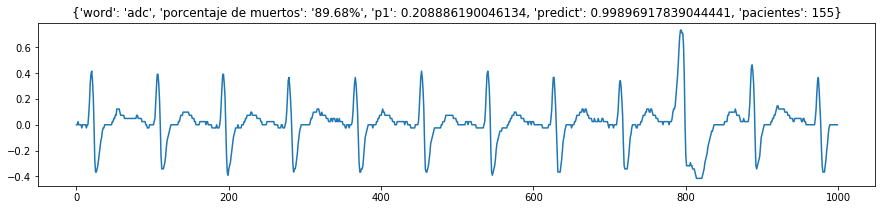

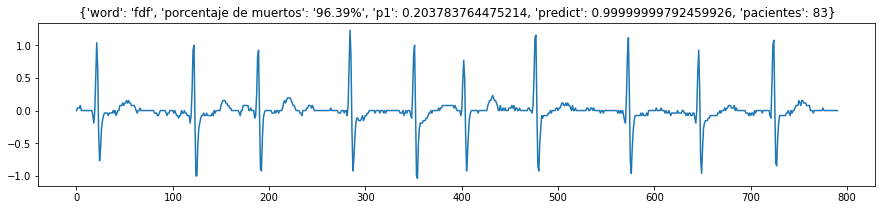

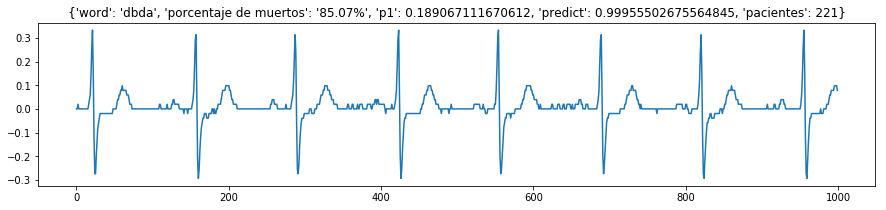

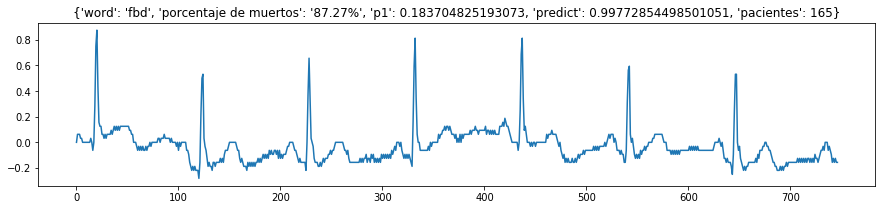

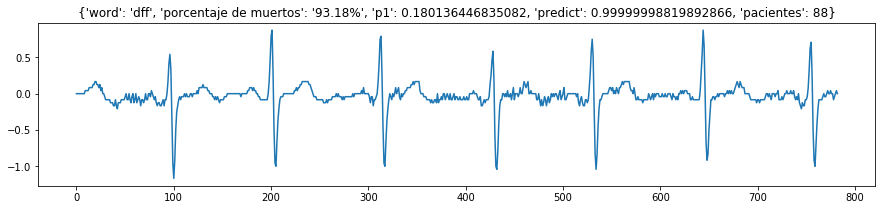

In [17]:
print("Top 5 HeartBeats con mayor probabilidad de muerte según la regresión logística")
print(sortedBeats[:5])
plot_word(sortedBeats[:5])

In [19]:
from operator import itemgetter
from scipy.stats.stats import pearsonr
patients_trainnmf = bestNmf.transform(patients_train)
pearsonList = []
for i in range(bestScore):
    patientpear=patients_trainnmf[:,i]
    pearson = pearsonr(patientpear,survived_train)
  #  if(pearson[0]>0):
    pearsonList.append({'group':i,'p1':pearson[0],'p2':pearson[1]})
sortedList = sorted(pearsonList, key=itemgetter('p1'), reverse=True)
sortedList[:10]

[{'group': 21, 'p1': 0.13044650191163473, 'p2': 0.005967137111806492},
 {'group': 17, 'p1': 0.10427377596955462, 'p2': 0.028199940155980107},
 {'group': 9, 'p1': 0.095499927541913582, 'p2': 0.044541848155571072},
 {'group': 3, 'p1': 0.081732343065442636, 'p2': 0.085745147417275319},
 {'group': 22, 'p1': 0.079307229051264291, 'p2': 0.095487626707498649},
 {'group': 16, 'p1': 0.076429400018931601, 'p2': 0.10817326069712921},
 {'group': 12, 'p1': 0.076069031756388919, 'p2': 0.10985134763031211},
 {'group': 0, 'p1': 0.075078081139811612, 'p2': 0.1145716041416265},
 {'group': 14, 'p1': 0.070560060298092211, 'p2': 0.13813549836033989},
 {'group': 13, 'p1': 0.069295322570442214, 'p2': 0.14535727344025132}]

In [20]:
columns = list(table)
components = bestNmf.components_
topword = print_top_words(components, columns,topic_index=sortedList[0]['group'])[0]['features']
subwords = []
for subword in topword:
    if subword['p1']>0:
        subwords.append(subword['word'])
print(str(subwords[:10]))

['adcd', 'aadc', 'aagh', 'badc', 'fga', 'ajda', 'gfaf', 'ffda', 'abbdd', 'fgf']


In [21]:
table = convert_matrix(sumvals=False,filter_words=tuple(subwords))
survived = table.index.labels[1].tolist()
patients = table.values
table

(540, 232)


,,aabadd,aabaf,aabafb,aabaga,aabbg,aabbgb,aabdad,aabdb,aabdbb,aacda,...,gfd,gff,gha,haf,hag,haj,hbf,hfa,hfg,hga
subject_id,isAlive,,,,,,,,,,,,,,,,,,,,,
135,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
151,1,1,0,0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
177,1,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
214,1,0,1,0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
279,1,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
283,1,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
368,1,0,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
377,1,1,1,1,1,0,0,1,1,1,0,...,1,0,0,1,0,0,0,1,0,0
408,1,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
patients_train, patients_test,survived_train, survived_test = train_test_split(patients,survived,test_size=0.2, random_state=42)
print(table.shape)
print(patients_train.shape)
print(patients_test.shape)

(540, 232)
(432, 232)
(108, 232)


In [23]:
model,acurracy = ajustLogisticRegression(patients_train,survived_train,patients_test,survived_test)

acurracy is 77.78%


In [24]:
logit_roc_auc = auc_model("Logistic",model,patients_test,survived_test)

Logistic AUC = 0.5002f


In [25]:
columns = list(table.columns.values)
pearsonList = []
for i in range(len(columns)):
    pearson = pearsonr(patients[:,i],survived)
    word = columns[i]
    count = countPatients(word)
    deadPatient,patient = count['deadPatient'],count['patient']
    percent = deadPatient/patient
    pearsonList.append({'word':word,'p1':pearson[0],'p2':pearson[1],'percent':"{0:.2%}".format(percent)+" de %d" %patient})

In [26]:
pearsonList = sorted(pearsonList, key=itemgetter('p1'), reverse=True)
pearsonList[:5]

[{'p1': 0.20629619960424944,
  'p2': 1.3322321476546345e-06,
  'percent': '89.68% de 155',
  'word': 'adc'},
 {'p1': 0.18111123938083684,
  'p2': 2.2961628993734019e-05,
  'percent': '85.07% de 221',
  'word': 'dbda'},
 {'p1': 0.17845426123218194,
  'p2': 3.0350870577087259e-05,
  'percent': '87.27% de 165',
  'word': 'fbd'},
 {'p1': 0.17579442910616386,
  'p2': 3.9969076433626121e-05,
  'percent': '91.26% de 103',
  'word': 'ffd'},
 {'p1': 0.17161281097954326,
  'p2': 6.1117120579637452e-05,
  'percent': '95.45% de 66',
  'word': 'haf'}]